# Import bibliothèques - CSV

In [ ]:
# Importation des librairies

import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

In [ ]:
# Connexion avec Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import CSV

la_poule_qui_chante = pd.read_csv('/content/drive/MyDrive/Formation DATA ANALYST/P11/la_poule_qui_chante.csv')

In [ ]:
# Vérif import

la_poule_qui_chante.head()

,id_pays,pays,Dispo_int_tonne,Export_tonne,Import_tonne,Prod_tonne,Var_stock_tonne,pib_22,%_aug_pib_17_22,pol_sta_22,delta_polsta_17_22,pop_22,%_aug_pop_17_22,distance_km
0,100,Bulgarie,143000.0,44000.0,90000.0,113000.0,17000.0,32433.1,21.56,0.31,-0.01,6825864,-3.53,1837.144598
1,108,Burundi,8000.0,0.0,0.0,8000.0,0.0,829.4,-5.86,-1.19,0.81,13321097,15.77,6151.396386
2,112,Bélarus,336000.0,192000.0,16000.0,512000.0,0.0,26537.5,4.05,-0.80,-0.74,9173237,-3.40,1996.292762
3,116,Cambodge,31000.0,0.0,7000.0,26000.0,2000.0,6458.4,14.67,-0.10,-0.19,17201724,7.02,9934.941747
4,120,Cameroun,124000.0,1000.0,2000.0,123000.0,0.0,4843.7,0.95,-1.38,-0.29,27632771,14.52,4556.467295


# Préparation des données

In [ ]:
# pays en index pour ne pas avoir de colonne avec du texte et suppression de id_pays

df = la_poule_qui_chante.drop(columns='id_pays').set_index('pays')

# Heatmap des corrélations

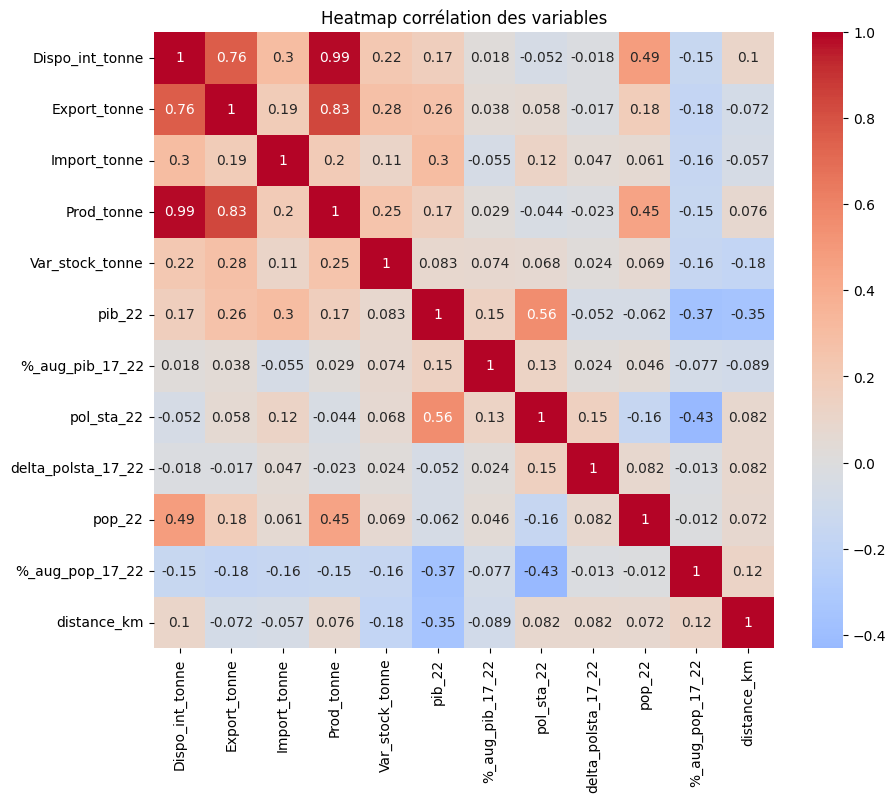

In [ ]:
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title("Heatmap corrélation des variables")
plt.show()


Il est important de commencer par une heatmap de corrélation pour :

* Identifier les variables fortement liées entre elles (corrélation positive ou négative).

* Repérer d’éventuelles redondances qui pourraient influencer l’ACP ou le clustering.

Dans notre cas, on observe notamment :

Une corrélation très forte entre Dispo_int_tonne, Prod_tonne et Export_tonne.
Ces variables décrivent une même dynamique : les pays qui produisent beaucoup ont logiquement plus de disponibilité interne et exportent davantage.

Une corrélation modérée à forte entre pib_22 et pol_sta_22.
Les pays plus stables politiquement ont souvent un PIB plus élevé.

Certaines variables sont faiblement corrélées aux autres (delta_polsta_17_22, %_aug_pop_17_22).
Elles apportent une information complémentaire utile pour différencier les pays.

# ACP

In [ ]:
# récupération de la matrice de données

x = df.values
x[:5] # affiche les 5 premières lignes

array([[ 1.43000000e+05,  4.40000000e+04,  9.00000000e+04,
         1.13000000e+05,  1.70000000e+04,  3.24331000e+04,
         2.15600000e+01,  3.10000000e-01, -1.00000000e-02,
         6.82586400e+06, -3.53000000e+00,  1.83714460e+03],
       [ 8.00000000e+03,  0.00000000e+00,  0.00000000e+00,
         8.00000000e+03,  0.00000000e+00,  8.29400000e+02,
        -5.86000000e+00, -1.19000000e+00,  8.10000000e-01,
         1.33210970e+07,  1.57700000e+01,  6.15139639e+03],
       [ 3.36000000e+05,  1.92000000e+05,  1.60000000e+04,
         5.12000000e+05,  0.00000000e+00,  2.65375000e+04,
         4.05000000e+00, -8.00000000e-01, -7.40000000e-01,
         9.17323700e+06, -3.40000000e+00,  1.99629276e+03],
       [ 3.10000000e+04,  0.00000000e+00,  7.00000000e+03,
         2.60000000e+04,  2.00000000e+03,  6.45840000e+03,
         1.46700000e+01, -1.00000000e-01, -1.90000000e-01,
         1.72017240e+07,  7.02000000e+00,  9.93494175e+03],
       [ 1.24000000e+05,  1.00000000e+03,  2.0000000

In [ ]:
# récupération des nom de pays

names = df.index

In [ ]:
# on recupère les colonnes (features)

features = df.columns

In [ ]:
# mise à l'échelle des données (centrage - reduction)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [ ]:
# Vérification du scaling

idx = ["mean", "std"]
pd.DataFrame(x_scaled).describe().round(2).loc[idx, :]


,0,1,2,3,4,5,6,7,8,9,10,11
mean,-0.0,-0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# Calcul de l'ACP

pca = PCA()
pca.fit(x_scaled)

PCA()

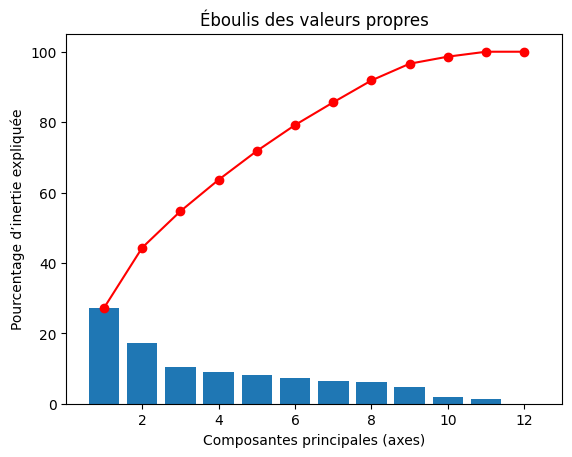

In [ ]:
# Eboulis des valeurs propres

scree = (pca.explained_variance_ratio_ * 100).round(2)
scree_cum = scree.cumsum().round(2)

plt.bar(range(1, len(scree)+1), scree)
plt.plot(range(1, len(scree)+1), scree_cum, c="red", marker='o')
plt.xlabel("Composantes principales (axes)")
plt.ylabel("Pourcentage d’inertie expliquée")
plt.title("Éboulis des valeurs propres")
plt.show()


Pour conserver 80% de l'information utile il faut 6 composants.

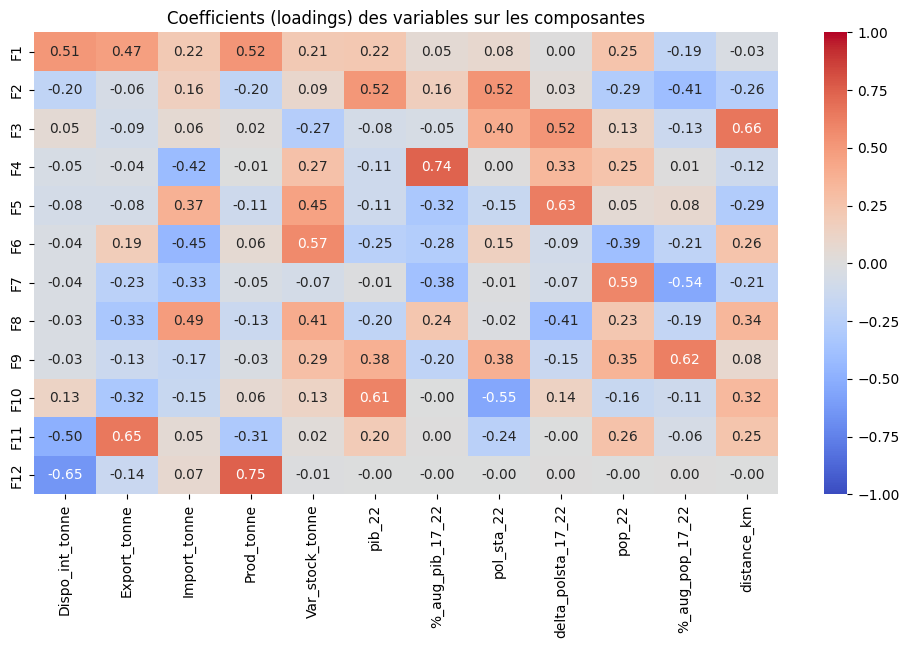

In [ ]:
# Analyse des coefficients de l'ACP (loadings)

pcs = pca.components_
n_comp = pcs.shape[0]

pcs_df = pd.DataFrame(
    pcs,
    index=[f"F{i}" for i in range(1, n_comp + 1)],
    columns=features
)

pcs_df.round(2)

plt.figure(figsize=(12, 6))
sns.heatmap(pcs_df, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Coefficients (loadings) des variables sur les composantes")
plt.show()

Cette heatmap présente les coefficients (loadings) qui indiquent dans quelle mesure chaque variable d’origine contribue à la construction des composantes principales F1 à F6.
Les valeurs proches de +1 / -1 indiquent une contribution forte ;
les valeurs proches de 0 indiquent que la variable n’influence pas cette composante.

Les composantes principales mettent en évidence plusieurs axes distincts :
F1 capture la dimension “production/exportation”, F2 la dynamique économique, F3 l’opposition géographique et politique, et F4 la stabilité politique actuelle.
Les axes suivants (F5 et F6) sont secondaires et expliquent moins de variance.

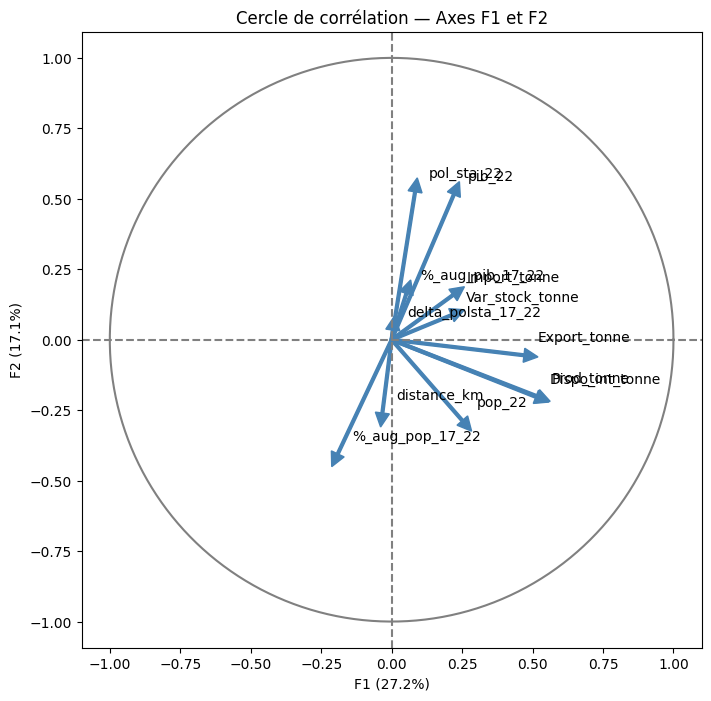

In [ ]:
# Projection des variables dans le cercle de corrélation (F1 - F2)

pca = PCA(n_components=6)
pca.fit(x_scaled)
x_cluster = pca.transform(x_scaled)

def cercle_correlation(pca, features, axes=(1,2)):
    i, j = axes[0]-1, axes[1]-1
    pcs = pca.components_

    fig, ax = plt.subplots(figsize=(8,8))
    for k in range(len(features)):
        ax.arrow(0, 0,
                 pcs[i, k],
                 pcs[j, k],
                 head_width=0.05,
                 head_length=0.05,
                 width=0.01,
                 color='steelblue')
        plt.text(pcs[i, k] + 0.05,
                 pcs[j, k] + 0.05,
                 features[k],
                 fontsize=10)

    # Cercle unité + axes de référence (hors boucle)
    an = np.linspace(0, 2 * np.pi, 200)
    plt.plot(np.cos(an), np.sin(an), color='gray')
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')

    plt.xlabel(f'F{axes[0]} ({pca.explained_variance_ratio_[i]*100:.1f}%)')
    plt.ylabel(f'F{axes[1]} ({pca.explained_variance_ratio_[j]*100:.1f}%)')
    plt.title(f"Cercle de corrélation — Axes F{axes[0]} et F{axes[1]}")
    plt.axis('equal')
    plt.show()

features = df.columns

cercle_correlation(pca, features, axes=(1,2))


**Dispo_int_tonne, Prod_tonne et Export_tonne**
→ Fortement corrélées positivement entre elles.
→ Elles contribuent surtout à F1 : plus un pays produit, plus il a de disponibilités et plus il exporte.

**pib_22 et pol_sta_22**
→ Corrélation positive modérée.
→ Elles sont orientées vers F2 : les pays stables politiquement sont souvent ceux avec un PIB plus élevé.

**Import_tonne, Var_stock_tonne**
→ Corrélations faibles à modérées.
→ Contribuent légèrement aux deux axes, mais plutôt du côté positif.

**%_aug_pop_17_22 et distance_km**
→ Situées du côté négatif de F2.
→ Elles s’opposent aux variables PIB / stabilité.

**delta_polsta_17_22**
→ Variable faiblement corrélée avec les autres, proche du centre.
→ Elle apporte une information indépendante (variation plutôt que niveau).

**pop_22**
→ Corrèle légèrement avec la production/export, mais moins fortement.

Le cercle de corrélation montre que la production, la disponibilité interne et les exportations sont fortement liées et tirent principalement l’axe F1.
L’axe F2 oppose les pays à fort PIB et politiquement stables à ceux ayant une croissance démographique élevée ou situés plus loin géographiquement.
Les variables de variation (delta_polsta ou croissance démographique) sont plus proches du centre et apportent une information complémentaire mais moins structurante.

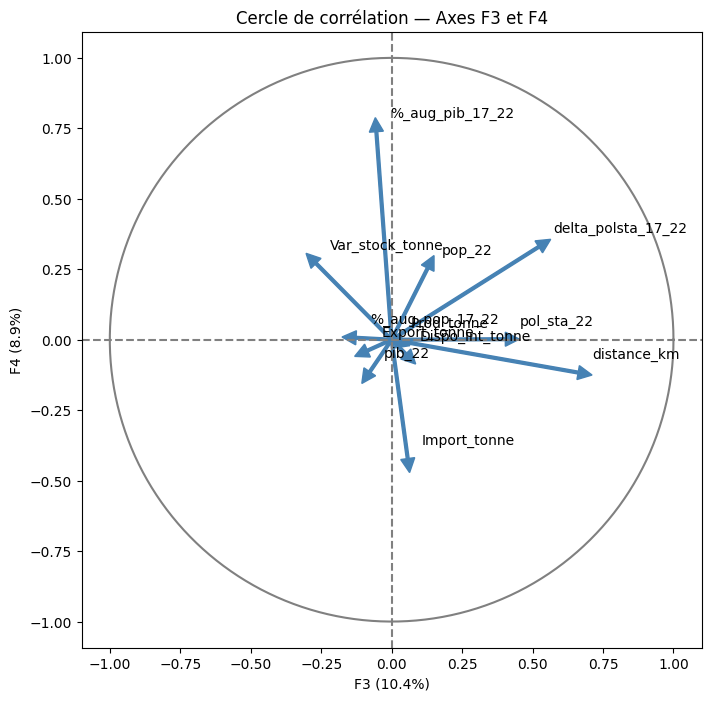

In [ ]:
# Projection sur F3 - F4

cercle_correlation(pca, features, axes=(3,4))

**%_aug_pib_17_22**
→ Très corrélé positivement à F4 : cet axe capture principalement la croissance économique.

**delta_polsta_17_22**
→ Corrélé positivement à F3 : cet axe représente plutôt la variation politique.

**distance_km**
→ Corrélé positivement à F3, mais de manière plus modérée.
→ Les pays éloignés sont associés à des niveaux différents de variation politique.

**Import_tonne**
→ Corrélé négativement à F4 : les pays ayant une croissance économique plus forte importent moins.

**Var_stock_tonne, pop_22**
→ Corrélations modérées, orientées positivement sur F3 et F4.

**Dispo_int_tonne, Prod_tonne, Export_tonne, pib_22, pol_sta_22**
→ Proches du centre.
→ Elles jouent un rôle faible sur ces axes : F3–F4 capturent d’autres dimensions (variations politiques et croissance économique).


L’axe F3 est surtout structuré par la variation de stabilité politique et la distance géographique, tandis que F4 reflète principalement la croissance du PIB.
Les variables liées à la production, la disponibilité ou le niveau de PIB sont proches du centre : elles ne contribuent que marginalement à ces axes secondaires.
Ce plan permet donc d’explorer des dimensions plus fines comme la dynamique économique et l’évolution politique des pays.

In [ ]:
# Projection des pays sur les composantes principales (scores ACP)

# Coordonnées des pays dans l'espace factoriel
X_proj = x_cluster  # = coordonnées F1..F6

df_scores = pd.DataFrame(
    X_proj,
    index=names,   # les pays
    columns=[f"F{i}" for i in range(1, 7)]   # F1 à F6
)

df_scores.head()


,F1,F2,F3,F4,F5,F6
pays,,,,,,
Bulgarie,0.173664,1.701811,-0.489526,0.757907,0.088104,0.205467
Burundi,-1.254587,-1.590741,1.039004,0.721105,2.244262,-0.109326
Bélarus,0.106911,0.519080,-2.089348,-0.742121,-1.452921,0.507719
Cambodge,-0.787919,-0.505693,0.468531,0.229299,-0.853933,0.612965
Cameroun,-1.086331,-1.547400,-1.309188,-0.221624,-0.151838,-0.041069


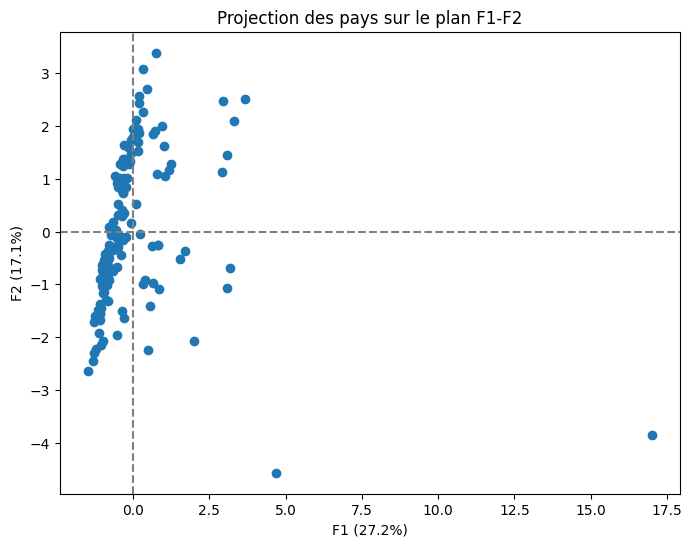

In [ ]:
# Projection des pays sur le plan F1-F2
plt.figure(figsize=(8, 6))
plt.scatter(df_scores["F1"], df_scores["F2"])
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.xlabel(f"F1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"F2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Projection des pays sur le plan F1-F2")
plt.show()


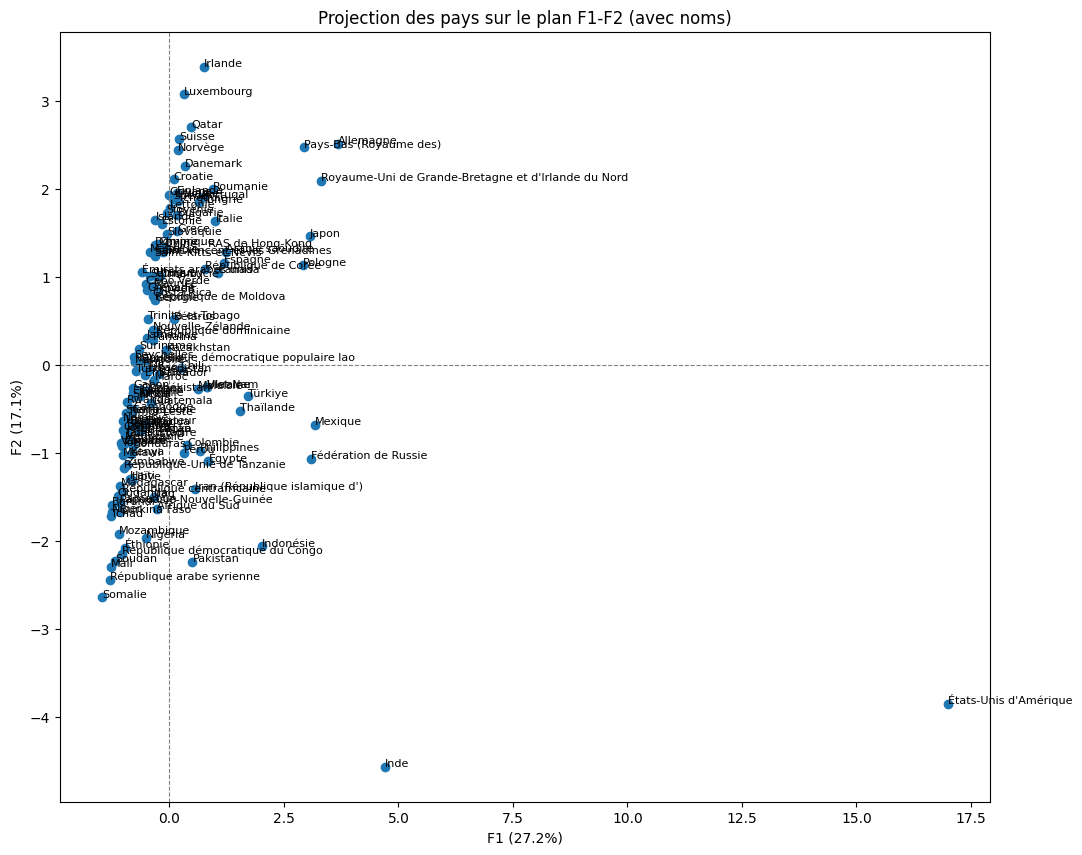

In [ ]:
# Projection des pays sur le plan F1-F2 (avec noms)

plt.figure(figsize=(12, 10))

# Nuage de points
plt.scatter(df_scores["F1"], df_scores["F2"])

# Ajout des axes horizontaux et verticaux
plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)

# Ajout des labels (noms des pays)
for country, x, y in zip(df_scores.index, df_scores["F1"], df_scores["F2"]):
    plt.text(x, y, country, fontsize=8)

# Noms et titres
plt.xlabel(f"F1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"F2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Projection des pays sur le plan F1-F2 (avec noms)")

plt.show()


# CAH

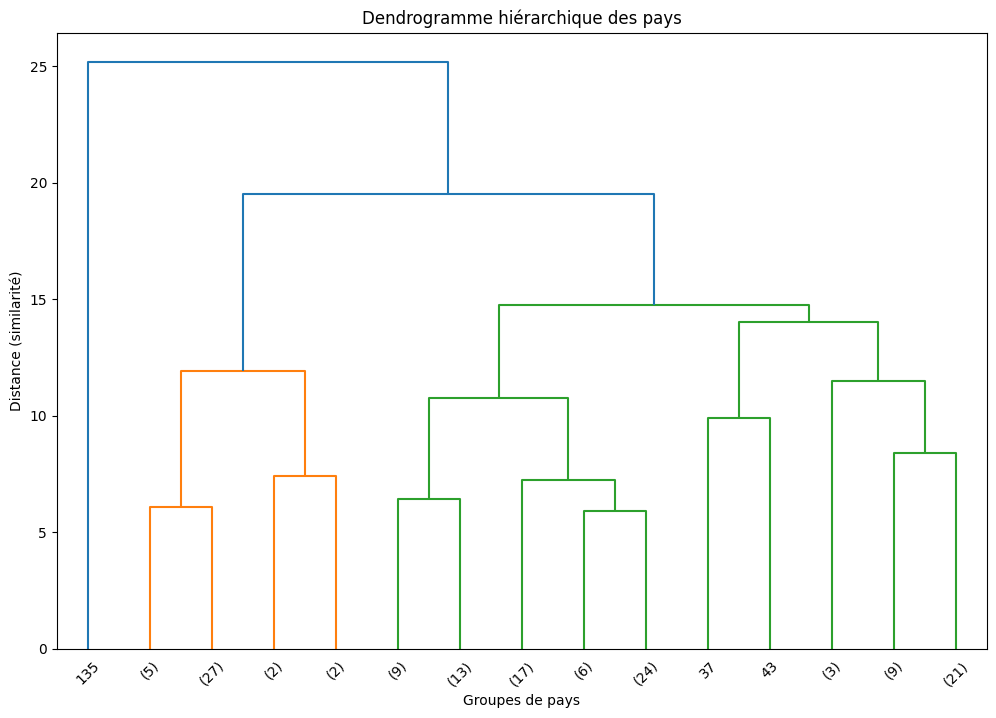

In [ ]:
# Clustering hiérarchique (CAH) — Dendrogramme des pays

Z = linkage(x_cluster, method='ward') # Z = l’historique complet des fusions utilisées pour construire le dendrogramme

plt.figure(figsize=(12, 8))
dendrogram(Z, truncate_mode='lastp', p=15, leaf_rotation=45, leaf_font_size=10)
plt.title("Dendrogramme hiérarchique des pays")
plt.xlabel("Groupes de pays")
plt.ylabel("Distance (similarité)")
plt.show()


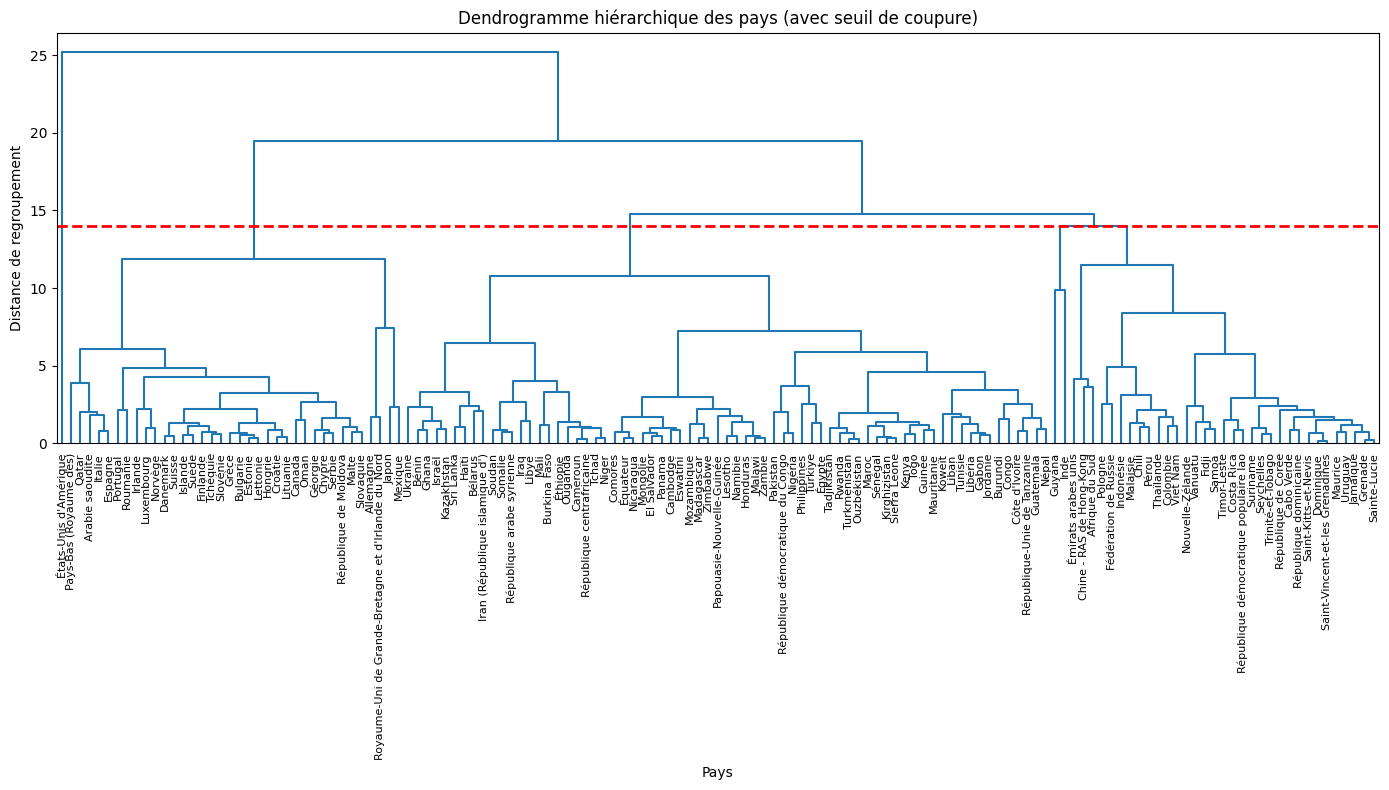

Seuil utilisé : 14


In [ ]:
# Dendrogramme avec le nom des pays
Z = linkage(x_cluster, method='ward')

# Dendrogramme avec seuil
plt.figure(figsize=(14, 8))
dendrogram(
    Z,
    labels=df.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=0  # couleurs neutres
)

# Ligne de coupure
seuil = 14
plt.axhline(y=seuil, color="red", linestyle="--", linewidth=2)

plt.title("Dendrogramme hiérarchique des pays (avec seuil de coupure)")
plt.xlabel("Pays")
plt.ylabel("Distance de regroupement")
plt.tight_layout()
plt.show()

print("Seuil utilisé :", seuil)


In [ ]:
# Création des groupes selon le seuil
clusters_cah = fcluster(Z, 14, criterion='distance')

# Ajouter les clusters dans df
df["cluster_cah"] = clusters_cah
df_scores["cluster_cah"] = clusters_cah

# Vérifier combien de pays dans chaque cluster
df["cluster_cah"].value_counts()

,count
cluster_cah,
2,69
1,36
4,33
3,2
5,1


On a donc 5 clusters mais un ou il n'y a qu'un seul pays, soit un outlier type USA ou Inde.

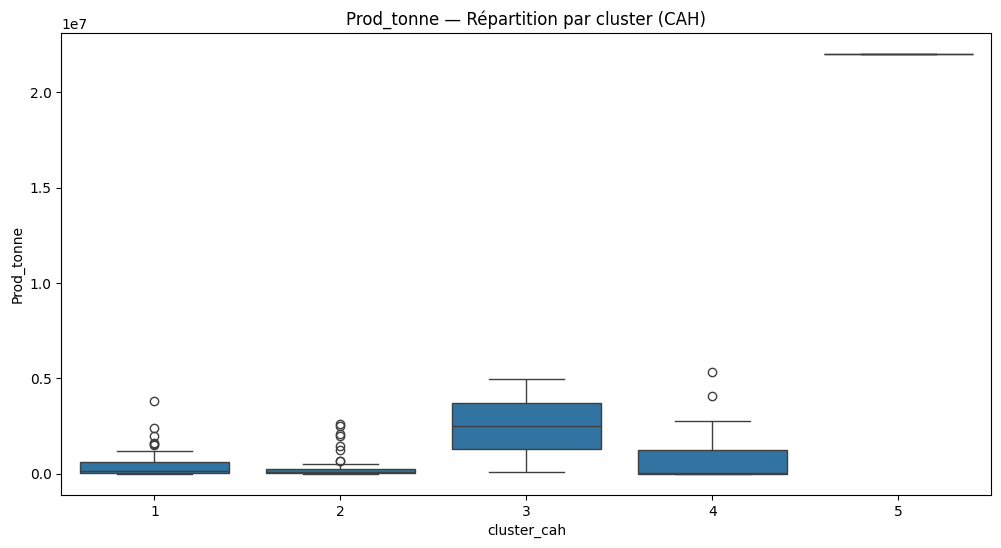

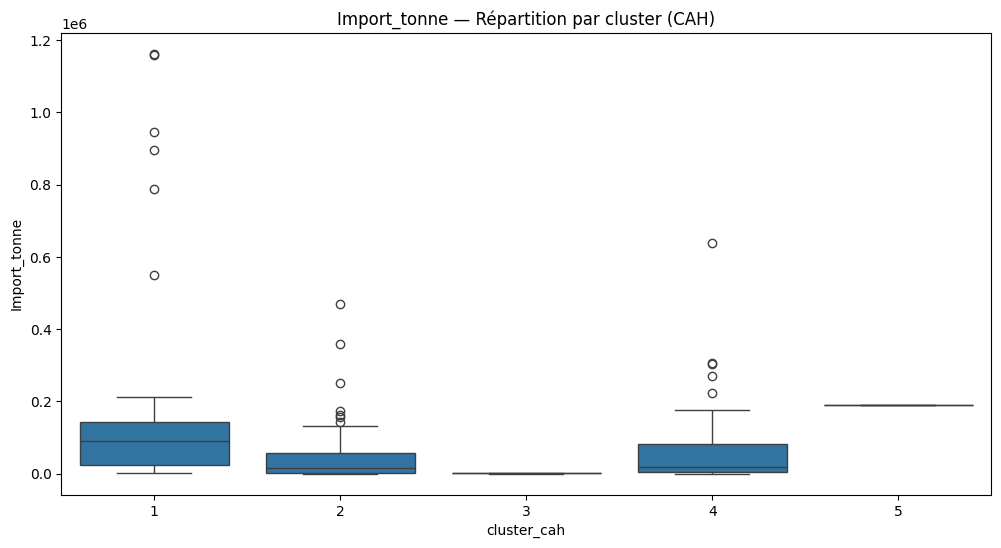

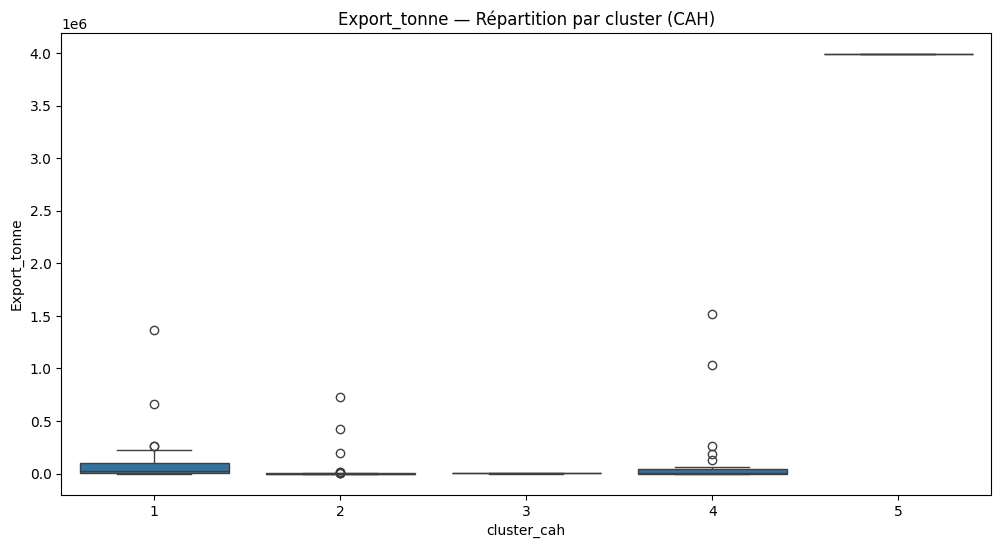

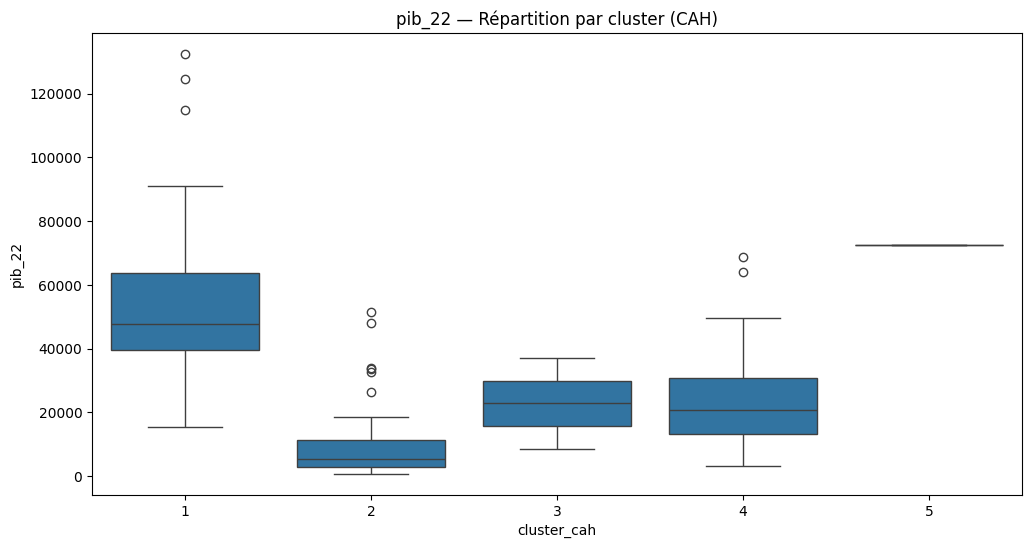

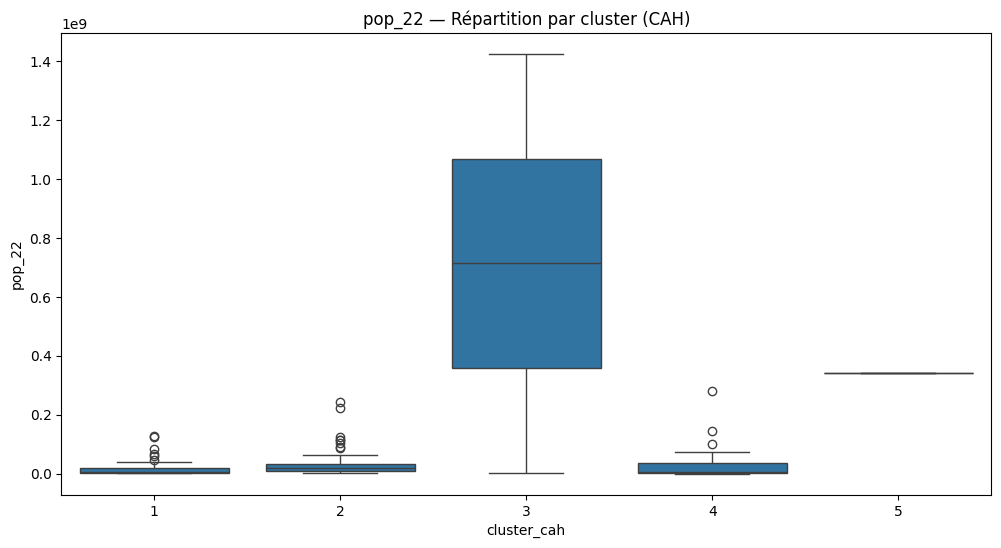

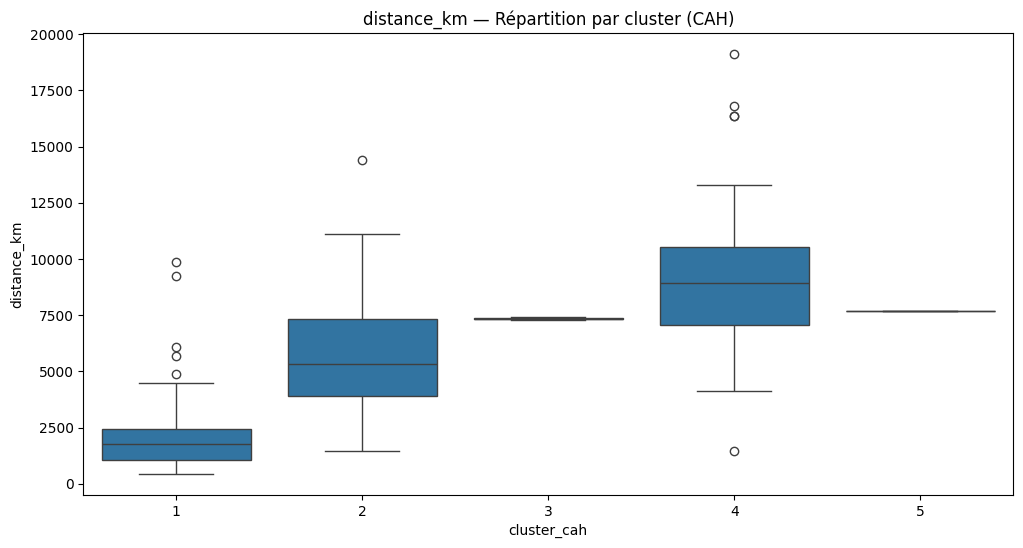

In [ ]:
# Variables analysée
vars_to_plot = ["Prod_tonne", "Import_tonne", "Export_tonne", "pib_22", "pop_22", "distance_km"]

# Boxplots pour chaque variable
for var in vars_to_plot:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x="cluster_cah", y=var)
    plt.title(f"{var} — Répartition par cluster (CAH)")
    plt.show()


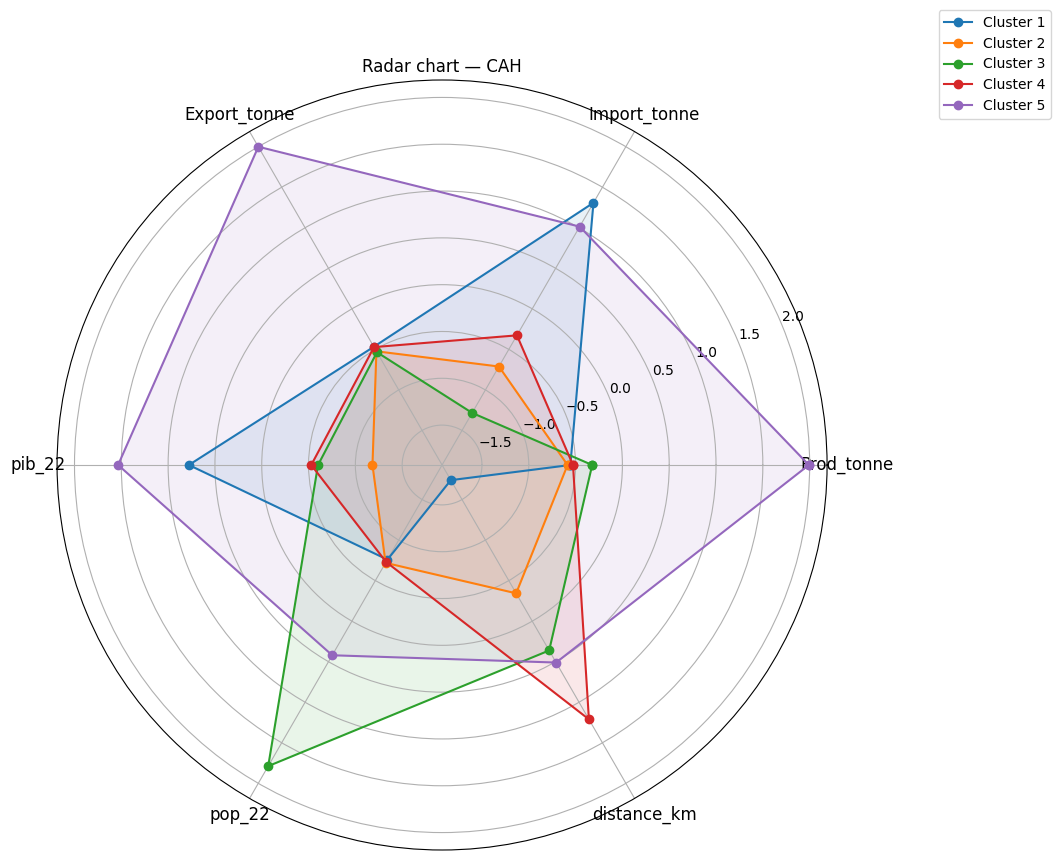

In [ ]:
# Graphique Radar

# Moyennes par cluster
cluster_means = df.groupby("cluster_cah")[vars_to_plot].mean()

# Standardisation (important pour radar)
scaler = StandardScaler()
cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means),
    index=cluster_means.index,
    columns=cluster_means.columns
)

import numpy as np

categories = vars_to_plot
N = len(categories)

# Angles des axes
angles = np.linspace(0, 2*np.pi, N, endpoint=False)
angles = np.concatenate([angles, [angles[0]]])  # boucle fermée

# 👉 création d'un axe POLAIRE
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Labels des axes
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)

# Option : fixer la limite du rayon (tu peux ajuster au besoin)
# ax.set_ylim(-2, 2)

for cluster in cluster_means_scaled.index:
    values = cluster_means_scaled.loc[cluster].values
    values = np.concatenate([values, [values[0]]])  # boucle fermée

    ax.plot(angles, values, marker="o", label=f"Cluster {cluster}")
    ax.fill(angles, values, alpha=0.1)

ax.set_title("Radar chart — CAH")
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))

plt.show()


# K-MEANS

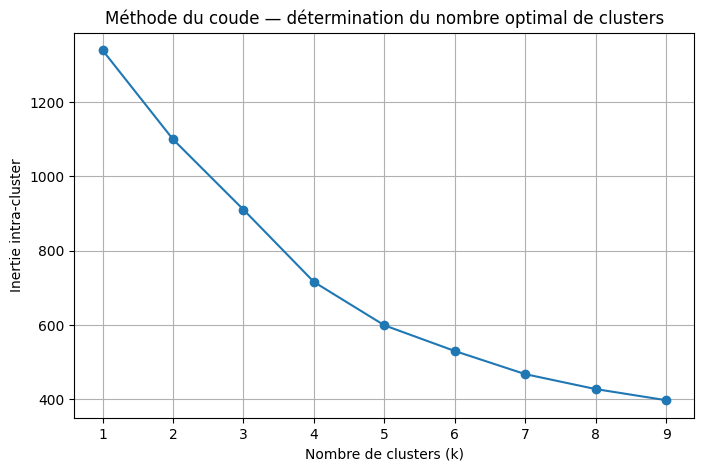

In [ ]:
# K-means — détermination du nombre optimal de clusters (méthode du coude)

intertia_list = []
k_list = range(1, 10)

for k in k_list:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_cluster)
    intertia_list.append(kmeans.inertia_)

# Tracé du coude
plt.figure(figsize=(8,5))
plt.plot(k_list, intertia_list, marker='o')
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie intra-cluster")
plt.title("Méthode du coude — détermination du nombre optimal de clusters")
plt.grid(True)
plt.show()


On observe :

une forte baisse de l’inertie entre k = 1 > 3,

puis la courbe s’aplatit à partir de k = 4 .

Cela signifie que :

jusqu’à 3 clusters, on gagne beaucoup en compacité (les groupes deviennent bien séparés),

au-delà de 4, le gain est faible = ajoute de la complexité sans réel bénéfice.

In [ ]:
# K-means (k = 4) — attribution du cluster à chaque pays

kmeans = KMeans(n_clusters=4, random_state=42)
labels = kmeans.fit_predict(x_cluster)
la_poule_qui_chante["cluster"] = labels

la_poule_qui_chante.head()

,id_pays,pays,Dispo_int_tonne,Export_tonne,Import_tonne,Prod_tonne,Var_stock_tonne,pib_22,%_aug_pib_17_22,pol_sta_22,delta_polsta_17_22,pop_22,%_aug_pop_17_22,distance_km,cluster
0,100,Bulgarie,143000.0,44000.0,90000.0,113000.0,17000.0,32433.1,21.56,0.31,-0.01,6825864,-3.53,1837.144598,2
1,108,Burundi,8000.0,0.0,0.0,8000.0,0.0,829.4,-5.86,-1.19,0.81,13321097,15.77,6151.396386,1
2,112,Bélarus,336000.0,192000.0,16000.0,512000.0,0.0,26537.5,4.05,-0.80,-0.74,9173237,-3.40,1996.292762,2
3,116,Cambodge,31000.0,0.0,7000.0,26000.0,2000.0,6458.4,14.67,-0.10,-0.19,17201724,7.02,9934.941747,1
4,120,Cameroun,124000.0,1000.0,2000.0,123000.0,0.0,4843.7,0.95,-1.38,-0.29,27632771,14.52,4556.467295,1


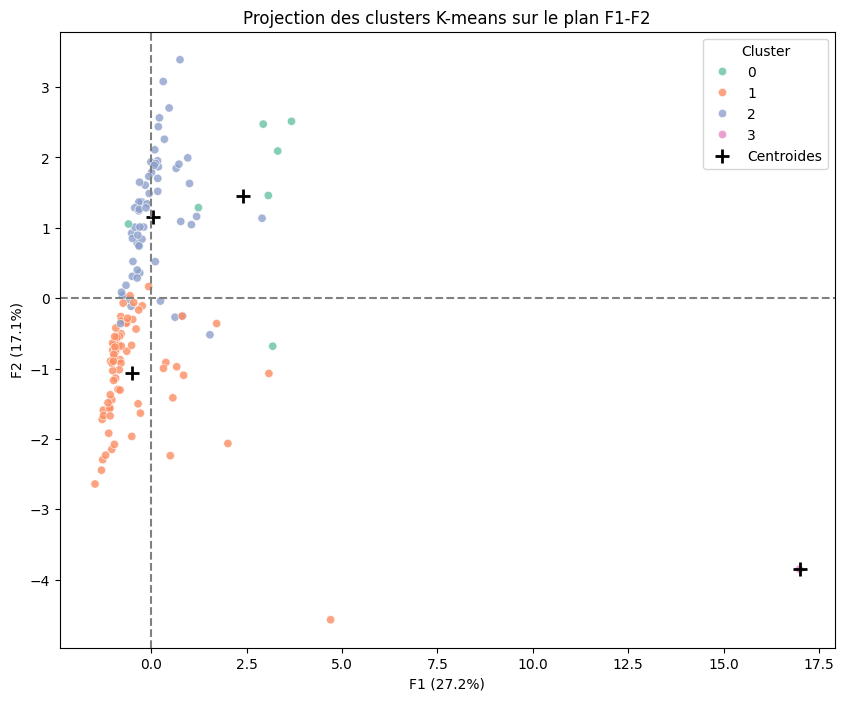

In [ ]:
# Projection des clusters K-means sur F1-F2

df_plot = df_scores.copy()
df_plot["cluster_km"] = la_poule_qui_chante["cluster"].values  # on ignore l'index, juste l'ordre

centroids = kmeans.cluster_centers_   # centres dans l'espace F1..F6
centroids_df = pd.DataFrame(centroids, columns=[f"F{i}" for i in range(1,7)])

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_plot,
    x="F1",
    y="F2",
    hue="cluster_km",
    palette="Set2",
    alpha=0.8
)

plt.scatter(
    centroids_df["F1"],
    centroids_df["F2"],
    marker="+",
    s=100,
    lw=2,
    c="black",
    label="Centroides"
)

plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')

plt.title("Projection des clusters K-means sur le plan F1-F2")
plt.xlabel(f"F1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"F2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(title="Cluster")

plt.show()


In [ ]:
# affiche la liste des pays par cluster

for c in sorted(la_poule_qui_chante["cluster"].unique()):
    print(f"\n=== Cluster {c} ===")
    pays_cluster = la_poule_qui_chante[la_poule_qui_chante["cluster"] == c]
    print(pays_cluster["pays"].sort_values().to_list())


=== Cluster 0 ===
['Allemagne', 'Arabie saoudite', 'Japon', 'Mexique', 'Pays-Bas (Royaume des)', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Émirats arabes unis']

=== Cluster 1 ===
['Afrique du Sud', 'Burkina Faso', 'Burundi', 'Bénin', 'Cambodge', 'Cameroun', 'Colombie', 'Comores', 'Congo', "Côte d'Ivoire", 'Eswatini', 'Fédération de Russie', 'Gabon', 'Ghana', 'Guatemala', 'Guinée', 'Haïti', 'Honduras', 'Inde', 'Indonésie', "Iran (République islamique d')", 'Iraq', 'Israël', 'Jordanie', 'Kazakhstan', 'Kenya', 'Kirghizistan', 'Lesotho', 'Liban', 'Libye', 'Libéria', 'Madagascar', 'Malawi', 'Mali', 'Maroc', 'Mauritanie', 'Mozambique', 'Namibie', 'Nicaragua', 'Niger', 'Nigéria', 'Népal', 'Ouganda', 'Ouzbékistan', 'Pakistan', 'Papouasie-Nouvelle-Guinée', 'Philippines', 'Pérou', 'Rwanda', 'République arabe syrienne', 'République centrafricaine', 'République démocratique du Congo', 'République-Unie de Tanzanie', 'Sierra Leone', 'Somalie', 'Soudan', 'Sri Lanka', 'Sénégal', 'Tadji

In [ ]:
# Calcul des moyennes par clusters

cluster_means = la_poule_qui_chante.groupby("cluster").mean(numeric_only=True)
cluster_means.round(2)

,id_pays,Dispo_int_tonne,Export_tonne,Import_tonne,Prod_tonne,Var_stock_tonne,pib_22,%_aug_pib_17_22,pol_sta_22,delta_polsta_17_22,pop_22,%_aug_pop_17_22,distance_km
cluster,,,,,,,,,,,,,
0,567.43,2179285.71,351714.29,877571.43,1670000.00,16428.57,55664.14,4.00,0.37,0.07,6.659973e+07,3.62,4451.32
1,493.10,564819.44,21805.56,50013.89,535555.56,-1055.56,8569.67,3.46,-0.83,-0.03,5.785624e+07,10.20,6153.50
2,455.75,296836.07,77163.93,64819.67,314163.93,4901.64,40458.58,11.32,0.57,-0.03,1.130037e+07,2.54,5350.23
3,840.00,18130000.00,3994000.00,191000.00,22030000.00,97000.00,72679.30,9.86,0.01,-0.25,3.415340e+08,2.81,7699.37


In [ ]:
# Calcul du nombre de pays pas clusters

la_poule_qui_chante["cluster"].value_counts().sort_index()

,count
cluster,
0,7
1,72
2,61
3,1


In [ ]:
# Variables à comparer et standardiser pour le graphique en barre

vars_to_plot = ["pib_22", "pop_22", "pol_sta_22", "distance_km", "Prod_tonne"]

scaler = StandardScaler()

cluster_means_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_means[vars_to_plot]),
    columns=vars_to_plot,
    index=cluster_means.index
)

cluster_means_scaled

,pib_22,pop_22,pol_sta_22,distance_km,Prod_tonne
cluster,,,,,
0,0.479918,-0.405547,0.641005,-1.224735,-0.486120
1,-1.516465,-0.472802,-1.606413,0.200924,-0.609563
2,-0.164661,-0.830912,1.003542,-0.471852,-0.633654
3,1.201208,1.709261,-0.038134,1.495663,1.729336


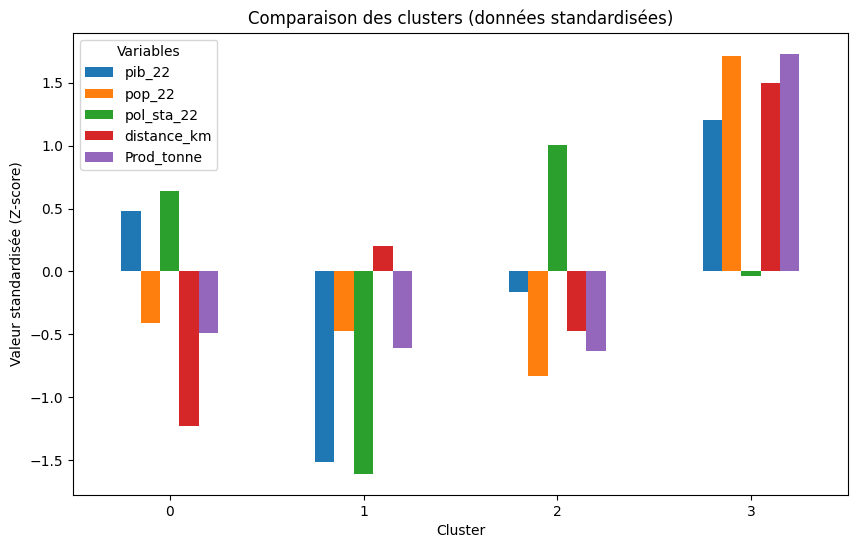

In [ ]:
# Graphique en barre des valeurs standardisées

cluster_means_scaled.plot(kind="bar", figsize=(10,6))
plt.title("Comparaison des clusters (données standardisées)")
plt.xlabel("Cluster")
plt.ylabel("Valeur standardisée (Z-score)")
plt.xticks(rotation=0)
plt.legend(title="Variables")
plt.show()


0 = moyenne globale

sup 0 = au-dessus de la moyenne

< 0 = en dessous de la moyenne

+1 = beaucoup plus que la moyenne

–1 = beaucoup moins que la moyenne

Conclusion :
Le cluster le plus favorable pour s'implater sur le marché est le 2

PIB : +0.6 (bons niveaux de richesse)

Stabilité : +1.1 (très bonne stabilité politique)

Distance : –1.0 (beaucoup plus proches de la France ; logistique facile)

Population : –0.8 (petits pays ?)

Production : –0.7 (production interne faible, donc importateurs)

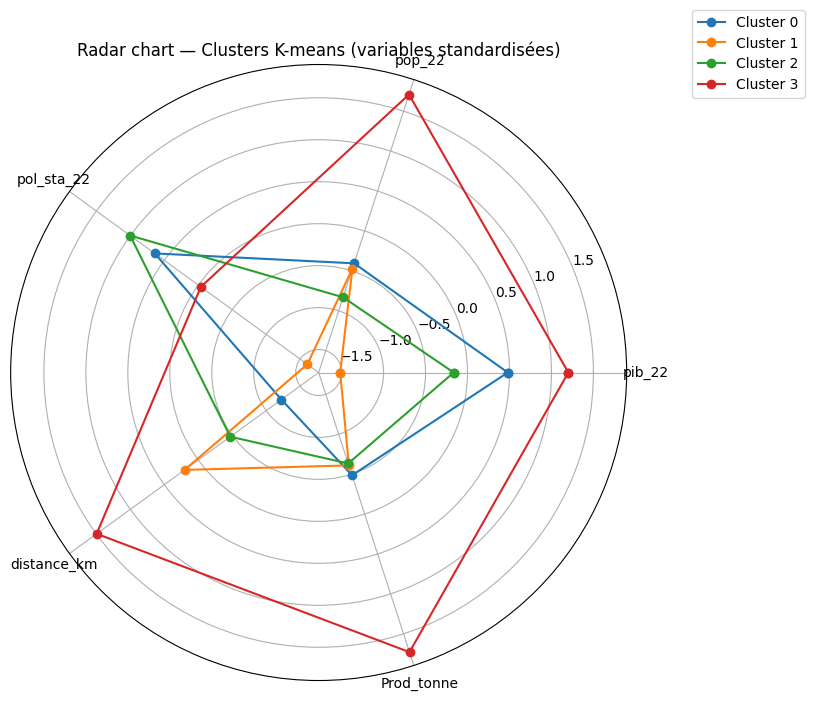

In [ ]:
# Radar K-means

categories = vars_to_plot               # ["pib_22", "pop_22", "pol_sta_22", "distance_km", "Prod_tonne"]
N = len(categories)

# Angles pour le radar
angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
angles = np.concatenate([angles, [angles[0]]])  # on boucle

plt.figure(figsize=(8, 8))

for cluster in cluster_means_scaled.index:
    values = cluster_means_scaled.loc[cluster, categories].values
    values = np.concatenate([values, [values[0]]])  # on boucle aussi les valeurs

    plt.polar(angles, values, marker="o", label=f"Cluster {cluster}")

# Labels des axes
plt.xticks(angles[:-1], categories)
plt.title("Radar chart — Clusters K-means (variables standardisées)")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()

In [ ]:
# Filtrer uniquement le cluster 0
cluster2 = la_poule_qui_chante[la_poule_qui_chante["cluster"] == 0].copy()

# Garder seulement les colonnes utiles pour le choix des pays
cols_utiles = [
    "pays",
    "Dispo_int_tonne",
    "Export_tonne",
    "Import_tonne",
    "Prod_tonne",
    "pib_22",
    "%_aug_pib_17_22",
    "pol_sta_22",
    "delta_polsta_17_22",
    "pop_22",
    "%_aug_pop_17_22",
    "distance_km"
]

cluster2 = cluster2[cols_utiles]
cluster2.head()


,pays,Dispo_int_tonne,Export_tonne,Import_tonne,Prod_tonne,pib_22,%_aug_pib_17_22,pol_sta_22,delta_polsta_17_22,pop_22,%_aug_pop_17_22,distance_km
31,Allemagne,1462000.0,664000.0,789000.0,1507000.0,62932.0,1.52,0.63,0.06,84086227,1.18,728.812222
52,Japon,3510000.0,4000.0,1163000.0,2372000.0,44972.3,1.05,1.03,-0.07,124997578,-1.63,9882.741244
74,Mexique,4950000.0,8000.0,1158000.0,3800000.0,21392.1,-1.77,-0.69,0.12,128613117,4.22,9220.390283
82,Pays-Bas (Royaume des),408000.0,1365000.0,897000.0,876000.0,71324.0,8.62,0.73,-0.18,17904421,3.40,743.150537
104,Arabie saoudite,1659000.0,21000.0,551000.0,1130000.0,67178.6,15.94,-0.36,0.29,32175352,4.53,4459.623248


In [ ]:
# Copier le DF du cluster 0 pour ne pas modifier le df d'origine
cluster2 = la_poule_qui_chante[la_poule_qui_chante["cluster"] == 0].copy()

# Tri multi-critères par ordre de priorité
top15_cluster2 = cluster2.sort_values(
    by=[
        "Import_tonne",        # importe beaucoup
        "Prod_tonne",          # produit peu
        "%_aug_pop_17_22",     # population croissante
        "pib_22",              # PIB élevé
        "pol_sta_22",          # stabilité politique
        "distance_km"          # proximité
    ],
    ascending=[
        False,   # Import_tonne : plus = mieux
        True,    # Prod_tonne : moins = mieux
        False,   # %_aug_pop_17_22 : plus = mieux
        False,   # PIB : plus = mieux
        False,   # pol_sta : plus = mieux
        True     # distance : moins = mieux
    ]
)

top15_cluster2.head(15)



,id_pays,pays,Dispo_int_tonne,Export_tonne,Import_tonne,Prod_tonne,Var_stock_tonne,pib_22,%_aug_pib_17_22,pol_sta_22,delta_polsta_17_22,pop_22,%_aug_pop_17_22,distance_km,cluster
52,392,Japon,3510000.0,4000.0,1163000.0,2372000.0,20000.0,44972.3,1.05,1.03,-0.07,124997578,-1.63,9882.741244,0
74,484,Mexique,4950000.0,8000.0,1158000.0,3800000.0,0.0,21392.1,-1.77,-0.69,0.12,128613117,4.22,9220.390283,0
133,826,Royaume-Uni de Grande-Bretagne et d'Irlande du...,2507000.0,267000.0,947000.0,1952000.0,125000.0,52982.2,2.68,0.53,0.15,68179315,2.75,915.143316,0
82,528,Pays-Bas (Royaume des),408000.0,1365000.0,897000.0,876000.0,0.0,71324.0,8.62,0.73,-0.18,17904421,3.40,743.150537,0
31,276,Allemagne,1462000.0,664000.0,789000.0,1507000.0,170000.0,62932.0,1.52,0.63,0.06,84086227,1.18,728.812222,0
126,784,Émirats arabes unis,759000.0,133000.0,638000.0,53000.0,-201000.0,68867.8,-0.01,0.74,0.14,10242086,10.91,5209.361633,0
104,682,Arabie saoudite,1659000.0,21000.0,551000.0,1130000.0,1000.0,67178.6,15.94,-0.36,0.29,32175352,4.53,4459.623248,0


# Comparaison des méthodes de clustering

In [ ]:
# On ajoute CAH dans la_poule_qui_chante
la_poule_qui_chante["cluster_cah"] = clusters_cah

# Et on renomme le cluster K-means pour être clair
la_poule_qui_chante["cluster_km"] = la_poule_qui_chante["cluster"]


In [ ]:
pd.crosstab(
    la_poule_qui_chante["cluster_cah"],
    la_poule_qui_chante["cluster_km"]
)

cluster_km,0,1,2,3
cluster_cah,,,,
1,6,0,30,0
2,0,64,5,0
3,0,1,1,0
4,1,7,25,0
5,0,0,0,1


Certains clusters sont très stables

CAH 2 ↔ K-means 1 : 64 pays
→ Très forte cohérence : les deux méthodes retrouvent le même groupe.

CAH 4 ↔ K-means 2 : 25 pays
→ Cohérence également forte.

Certains clusters sont “mixtes”

CAH 1 est réparti entre K-means 0 (6 pays) et K-means 2 (30 pays).

CAH 3 contient seulement 2 pays, répartis entre K-means 1 et 2.

CAH 5 correspond à un seul pays.

Pourquoi ces différences :

La CAH et le K-means n’optimisent pas la même chose

CAH = distances hiérarchiques

K-means = centrage autour de moyennes

Certains clusters sont petits ou atypiques, donc plus difficiles à stabiliser.

La représentation en 6 composantes (ACP) influence légèrement le découpage.